Model architecture adapted from:
Juho Laitala, Mingzhe Jiang, Elise Syrjälä, Emad Kasaeyan Naeini, Antti
Airola, Amir M. Rahmani, Nikil D. Dutt, and Pasi Liljeberg. 2020. Robust
ECG R-peak Detection Using LSTM. In The 35th ACM/SIGAPP Symposium
on Applied Computing (SAC ’20), March 30-April 3, 2020, Brno, Czech Republic
ACM, New York, NY, USA, Article 4, 8 pages. https://doi.org/10.1145/3341105.
3373945

In [7]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(".."))

# Importing needed libraries
from matplotlib import pyplot as plt
from RNN_files import Laitala_data_original_file
import wfdb
from wfdb.io import get_record_list
from wfdb import rdsamp
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from scipy.signal import resample_poly
import xarray as xr
import matplotlib.pyplot as plt
from RNN_files import Laitala_data_original_file
import tensorflow
from tensorflow.keras import layers, models, Input
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

Combine simulation datasets into one large dataset:

In [8]:
# Get all simulation files

path = '/nsls2/users/shasko/Repos/internship_2025/saved_data/'
# filenames = ['ds_combined_1_patterns_NaCl_cubic_width_peakslabeled_noisy',
#              'ds_combined_1_patterns_TiO2_tetragonal_width_peakslabeled_noisy',
#              'gaussian_functions_smalldataset_varying_amps',
#             'lorentzian_functions_smalldataset',
#             'psuedovoigt_functions_smalldataset']

# filenames = ['ds_combined_1_patterns_NaCl_cubic_width_peakslabeled_noisy',
            #  'ds_combined_1_patterns_TiO2_tetragonal_width_peakslabeled_noisy']

# filenames = ['lorentzian_functions_smalldataset_noisy_11763',
#              'psuedovoigt_functions_smalldataset_noisy_11763',
#              'gaussian_functions_smalldataset_varying_amps_noisy_11763',
#              'ds_combined_100_patterns_NaCl_cubic_width_peakslabeled_noisy']
filenames = ['lorentzian_functions_smalldataset_noisy_11763',
             'gaussian_functions_smalldataset_varying_amps_noisy_11763',
             'ds_combined_100_patterns_NaCl_cubic_width_peakslabeled_noisy']

In [9]:
full_paths = [f'{path}{i}.nc' for i in filenames]

In [10]:
all_datasets = [xr.open_dataset(p, engine='netcdf4') for p in full_paths] # list of all the Datasets

Next two cells just for visualization of something...will be deleted

In [ ]:
# y = all_datasets[2]["Intensities"].values
# x = all_datasets[2]["tth"].values

In [5]:
# plt.figure(figsize=(12,8))
# bin = all_datasets[2]["binary_arr"].values
# plt.plot(x, y[0], color='#00ADDC')
# idx = np.where(bin[0] == 1)
# # print(idx)
# # plt.scatter(x[idx], y[0][idx], marker='*', s=100,color='green')

In [11]:
import xarray as xr

# Add new pattern dimension when stacking
combined = xr.concat(all_datasets, dim="pattern")

In [12]:
print(all_datasets[0]["Intensities"].values.shape)
print(all_datasets[1]["Intensities"].values.shape)
print(all_datasets[2]["Intensities"].values.shape)


(5000, 11763)
(5000, 11763)
(100, 11763)


In [13]:
combined["Intensities"].values.shape

(10100, 11763)

Run this cell and not the one after if using simulated diffraction data. Run the one above these two if combining datasets.

In [ ]:
# path = '/nsls2/users/shasko/Repos/internship_2025/datasets/ds_combined_500_patterns_NaCl.nc'
# ds = xr.open_dataset(path, engine="netcdf4")
# gaussians = ds["Intensities"].values
# binary = ds["binary_arr"].values
# x = ds["tth"].values

# window_size = 11763

Run this cell and not the previous one if using simulated Gaussian signals.  Run the one above these two if combining datasets.

In [ ]:
# path = '/nsls2/users/shasko/Repos/internship_2025/saved_data/gaussian_functions_smalldataset_varying_amps_2.nc' 
# ds = xr.open_dataset(path, engine="netcdf4")

# gaussians = ds["Gaussians"].values
# binary = ds["BinaryArr"].values
# print(type(binary))

# x = ds["x"].values
# window_size = 1000

<class 'numpy.ndarray'>


In [14]:
window_size = combined["x"].shape[0]

In [15]:
gaussians = combined["Intensities"]
binary = combined["BinaryArr"]

In [16]:

tv_gaussians, test_gaussians, tv_binary, test_binary = train_test_split(gaussians, binary, test_size=0.2, shuffle=True, random_state=42)

In [17]:
train_gaussians, val_gaussians, train_binary, val_binary = train_test_split(tv_gaussians, tv_binary, test_size=0.25, shuffle=True, random_state=42)

I've scaled the intensities manually for better transparency: 

In [18]:
# train_gaussians_sc = scale_gauss.fit_transform(train_gaussians)
# val_gaussians_sc = scale_gauss.transform(val_gaussians)
# test_gaussians_sc = scale_gauss.transform(test_gaussians)

train_gaussians_sc = np.zeros_like(train_gaussians)
val_gaussians_sc = np.zeros_like(val_gaussians)
test_gaussians_sc = np.zeros_like(test_gaussians)

for j in range(train_gaussians.shape[0]):
    max_inten = np.max(train_gaussians[j])
    min_inten = np.min(train_gaussians[j])
    train_gaussians_sc[j] = (train_gaussians[j] - min_inten) / (max_inten - min_inten)

for j in range(val_gaussians.shape[0]):
    max_inten = np.max(val_gaussians[j])
    min_inten = np.min(val_gaussians[j])
    val_gaussians_sc[j] = (val_gaussians[j] - min_inten) / (max_inten - min_inten)

for j in range(test_gaussians.shape[0]):
    max_inten = np.max(test_gaussians[j])
    min_inten = np.min(test_gaussians[j])
    test_gaussians_sc[j] = (test_gaussians[j] - min_inten) / (max_inten - min_inten)

In [ ]:
n_batch, n_timesteps, n_input_dim = 16, window_size, 1

model = models.Sequential()
model.add(Input(shape=(n_timesteps, 16)))
model.add(layers.Bidirectional(layers.LSTM(8, return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(8, return_sequences=True)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [43]:
model.summary() # view model architecture

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_14 (Bidirectio (None, 11763, 16)         1600      
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 11763, 16)         1600      
_________________________________________________________________
dense_7 (Dense)              (None, 11763, 1)          17        
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
_________________________________________________________________


In [44]:
checkpoint_path = 'training_5/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create callback to save model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=2) 

es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                              patience=3,
                                              min_delta=1e-5,
                                              verbose=2)

In [45]:
train_gaussians_reshaped = train_gaussians_sc.reshape(train_gaussians_sc.shape[0], train_gaussians_sc.shape[1], 1)
val_gaussians_reshaped = val_gaussians_sc.reshape(val_gaussians_sc.shape[0], val_gaussians_sc.shape[1], 1)
test_gaussians_reshaped = test_gaussians_sc.reshape(test_gaussians_sc.shape[0], test_gaussians_sc.shape[1], 1)

In [46]:
train_binary = np.array(train_binary)
val_binary = np.array(val_binary)
test_binary = np.array(test_binary)

In [47]:
train_binary_reshaped = train_binary.reshape(train_binary.shape[0], train_binary.shape[1], 1)
val_binary_reshaped = val_binary.reshape(val_binary.shape[0], val_binary.shape[1], 1)
test_binary_reshaped = test_binary.reshape(test_binary.shape[0], test_binary.shape[1], 1)

In [48]:
model.fit(x=train_gaussians_reshaped,
          y=train_binary_reshaped,
          batch_size=16,
          epochs=20, 
          validation_data=(val_gaussians_reshaped, val_binary_reshaped),
          callbacks=[cp_callback, es_callback])

Epoch 1/20


ValueError: in user code:

    /nsls2/users/shasko/ecgenv/lib64/python3.6/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /nsls2/users/shasko/ecgenv/lib64/python3.6/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /nsls2/users/shasko/ecgenv/lib64/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /nsls2/users/shasko/ecgenv/lib64/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /nsls2/users/shasko/ecgenv/lib64/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /nsls2/users/shasko/ecgenv/lib64/python3.6/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /nsls2/users/shasko/ecgenv/lib64/python3.6/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /nsls2/users/shasko/ecgenv/lib64/python3.6/site-packages/keras/engine/base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /nsls2/users/shasko/ecgenv/lib64/python3.6/site-packages/keras/engine/sequential.py:369 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /nsls2/users/shasko/ecgenv/lib64/python3.6/site-packages/keras/engine/functional.py:415 call
        inputs, training=training, mask=mask)
    /nsls2/users/shasko/ecgenv/lib64/python3.6/site-packages/keras/engine/functional.py:550 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /nsls2/users/shasko/ecgenv/lib64/python3.6/site-packages/keras/layers/wrappers.py:583 __call__
        return super(Bidirectional, self).__call__(inputs, **kwargs)
    /nsls2/users/shasko/ecgenv/lib64/python3.6/site-packages/keras/engine/base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /nsls2/users/shasko/ecgenv/lib64/python3.6/site-packages/keras/layers/wrappers.py:699 call
        initial_state=forward_state, **kwargs)
    /nsls2/users/shasko/ecgenv/lib64/python3.6/site-packages/keras/layers/recurrent.py:659 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    /nsls2/users/shasko/ecgenv/lib64/python3.6/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /nsls2/users/shasko/ecgenv/lib64/python3.6/site-packages/keras/engine/input_spec.py:269 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer forward_lstm_14: expected shape=(None, None, 16), found shape=(None, 11763, 1)


In [28]:
binary_pred = model.predict(test_gaussians_reshaped,
                            verbose=2)

94/94 - 10s


In [29]:
binary_pred.shape

(3000, 1000, 1)

In [31]:
plt.close('all')

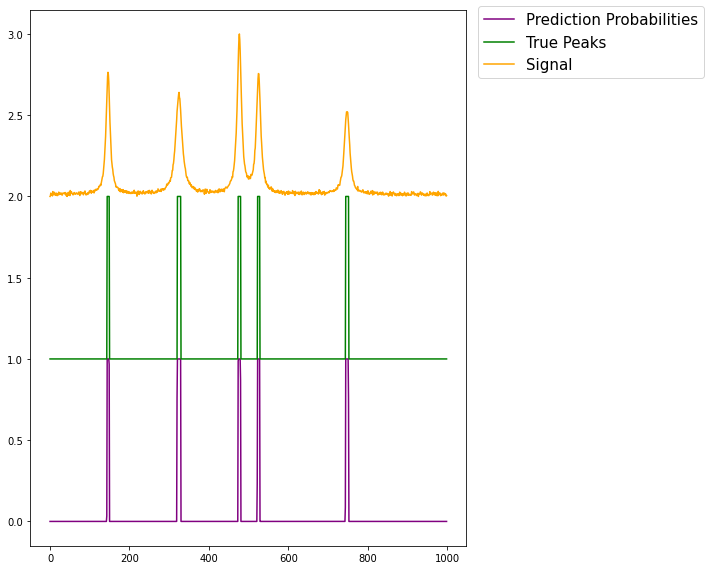

In [38]:
plt.figure(figsize=(10,8))
idx=5
plt.plot(binary_pred[idx], color='purple', label='Prediction Probabilities')
plt.plot(test_binary_reshaped[idx] + 1, color='green', label='True Peaks')
plt.plot(test_gaussians_reshaped[idx] + 2, color='orange', label='Signal')
plt.legend(bbox_to_anchor=(1.01, 1.02), loc='upper left', fontsize=15)
plt.tight_layout()
# plt.savefig('/nsls2/users/shasko/Repos/internship_2025/saved_figures/gaussian_jul2_idx12')
plt.show()

Evaluate accuracy: use f1 score, set prob >= 30% as positive, else negative


In [39]:
from sklearn.metrics import f1_score

In [60]:
threshold = 0.5
binary_pred_adjusted_sklearn = (binary_pred >= threshold).astype(int)
test_binary_reshaped = test_binary_reshaped.astype(int)
f1 = f1_score(test_binary_reshaped.squeeze(), binary_pred_adjusted_sklearn.squeeze(), average='micro')
print(f1)


0.9893674631163238


Try evaluating on non-similar data now...

In [42]:
path = '/nsls2/users/shasko/Repos/internship_2025/saved_data/psuedovoigt_functions_smalldataset_noisy.nc' 
ds = xr.open_dataset(path, engine="netcdf4")

intensities_lor = ds["Intensities"].values
binary = ds["BinaryArr"].values
print(type(binary))

x = ds["x"].values
window_size = 1000

<class 'numpy.ndarray'>


In [43]:
intensities_lor.shape

(5000, 1000)

Scale the intensity values within [0, 1]
Note: be careful if changing this to use MinMaxScaler because it scales by column not row

In [44]:
intensities_lor_sc = np.zeros_like(intensities_lor)

for j in range(intensities_lor.shape[0]):
    max_inten = np.max(intensities_lor[j])
    min_inten = np.min(intensities_lor[j])
    intensities_lor_sc[j] = (intensities_lor[j] - min_inten) / (max_inten - min_inten)

In [45]:
intensities_lor_sc.shape

(5000, 1000)

In [46]:
intensities_lor_sc_reshaped = intensities_lor_sc.reshape(intensities_lor_sc.shape[0],
                                                         intensities_lor_sc.shape[1],
                                                         1)

In [47]:
binary_lor_reshaped = binary.reshape(binary.shape[0],
                                 binary.shape[1],
                                 1)

In [48]:
pred_lor = model.predict(intensities_lor_sc_reshaped,
                         verbose=2)

KeyboardInterrupt: 

In [145]:
plt.close('all')

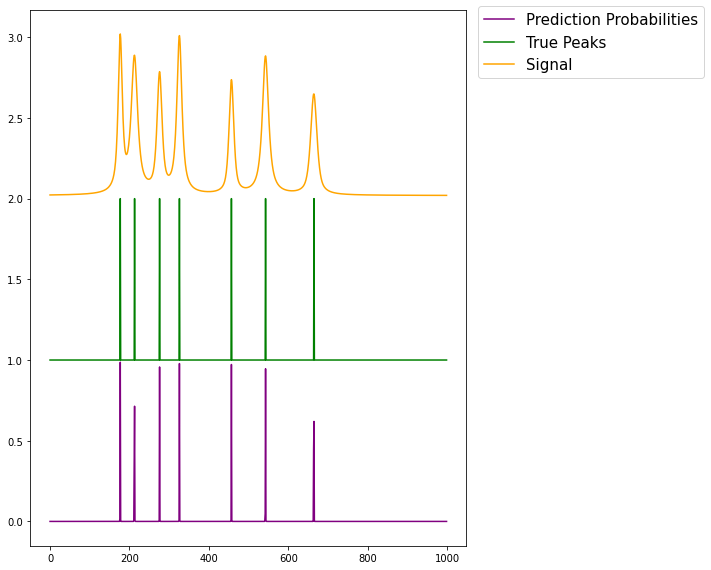

In [146]:
plt.figure(figsize=(10,8))
idx=4

plt.plot(pred_lor[idx], color='purple', label='Prediction Probabilities')
plt.plot(binary_lor_reshaped[idx] + 1, color='green', label='True Peaks')
plt.plot(intensities_lor_sc_reshaped[idx] + 2.02, color='orange', label='Signal')
plt.legend(bbox_to_anchor=(1.01, 1.02), loc='upper left', fontsize=15)
plt.tight_layout()
# plt.savefig('/nsls2/users/shasko/Repos/internship_2025/saved_figures/lorentz_jul2_idx9.png')
plt.show()

In [125]:
threshold = 0.5
pred_lor_adjusted_sklearn = (pred_lor >= threshold).astype(int)
binary_lor_reshaped = binary_lor_reshaped.astype(int)
f1 = f1_score(binary_lor_reshaped.squeeze(), pred_lor_adjusted_sklearn.squeeze(), average='micro')
print(f1)

0.5943529325540062


Try evaluating on diffraction data now...

In [49]:
path = '/nsls2/users/shasko/Repos/internship_2025/saved_data/ds_combined_1_patterns_NaCl_cubic_width_peakslabeled_noisy.nc'
ds = xr.open_dataset(path, engine="netcdf4")
intensities_diff = ds["Intensities"].values
binary_diff = ds["binary_arr"].values
x = ds["tth"].values

window_size = 11763

In [50]:
intensities_diff.shape

(1, 11763)

In [51]:
intensities_diff_sc = np.zeros_like(intensities_diff)

for j in range(intensities_diff.shape[0]):
    max_inten = np.max(intensities_diff[j])
    min_inten = np.min(intensities_diff[j])
    intensities_diff_sc[j] = (intensities_diff[j] - min_inten) / (max_inten - min_inten)

In [52]:
intensities_diff_sc_reshaped = intensities_diff_sc.reshape(intensities_diff_sc.shape[0],
                                                           intensities_diff_sc.shape[1],
                                                           1)

In [53]:
binary_diff_reshaped = binary_diff.reshape(binary_diff.shape[0],
                                           binary_diff.shape[1],
                                           1)

In [54]:
pred_diff = model.predict(intensities_diff_sc_reshaped,
                         verbose=2)

1/1 - 2s


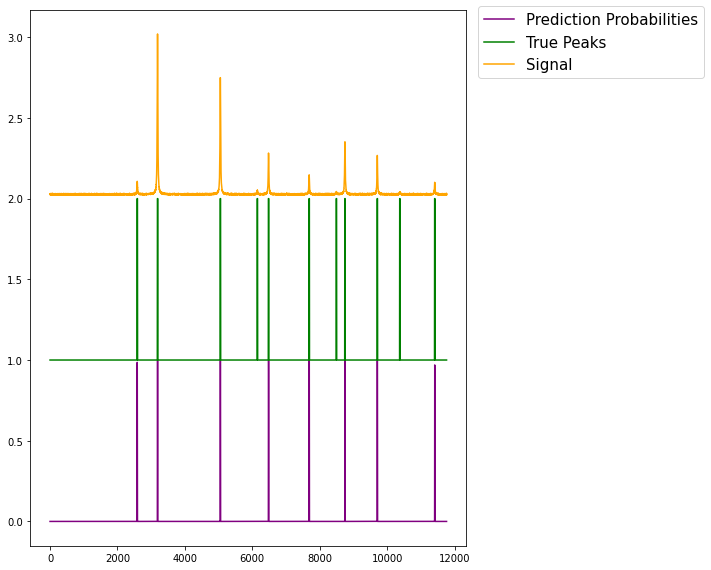

In [65]:
plt.figure(figsize=(10,8))
idx=0

plt.plot(pred_diff[idx], color='purple', label='Prediction Probabilities')
plt.plot(binary_diff_reshaped[idx] + 1, color='green', label='True Peaks')
plt.plot(intensities_diff_sc_reshaped[idx] + 2.02, color='orange', label='Signal')
plt.legend(bbox_to_anchor=(1.01, 1.02), loc='upper left', fontsize=15)
plt.tight_layout()
# plt.xlim(8000,9000)
# plt.savefig('/nsls2/users/shasko/Repos/internship_2025/saved_figures/diff_jul2_idx9.png')

plt.show()

In [135]:
threshold = 0.2
pred_diff_adjusted_sklearn = (pred_diff >= threshold).astype(int)
binary_diff_reshaped = binary_diff_reshaped.astype(int)
f1 = f1_score(binary_diff_reshaped.squeeze(), pred_diff_adjusted_sklearn.squeeze(), average='micro')
print(f1)

0.988268298903341
